https://dacon.io/competitions/official/235743/overview/description

In [23]:
import numpy as np
import pandas as pd

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline

from categorize import *
from feature_DropMake import *
from usefulmenu import SpicyViewer

import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 적제

In [3]:
train = pd.read_csv('./datasets/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [7]:
train, train_labels = train.drop(['중식계', '석식계'], axis=1), train[['중식계', '석식계']]

# 실험 목적

<h3 style='font-weight:normal'>1. 만들어 낸 특성 종류가 너무 많기 때문에 어떤 특성들이 성능이 좋고 어떤 특성들이 누락 가능한지 확인하기.</h3>

<h3 style='font-weight:normal'>2. 모델들을 튜닝하면서 성능이 어떻게 향상하는지 관찰하기. </h3>

<br/>모델들에 따라서 성능 좋은 특성들이 다를 수 있기 때문에 사용한 모든 모델은 트리기반으로 통일하였다.

# 2. 비교 모델 훈련해보기 (baseline)

**RandomForestRegressor 모델을 사용해서 직접 만든 특성들로 성능이 얼마나 나오는지 확인해보기**


- 구현한 커스텀 변환기들을 모두 적용했을 때 나오는 칼럼들

In [954]:
feature_eng = Pipeline([
    ('datetime', DayMonthMaker()),
    ('office_workers', OfficeCount()),
    ('categorize', MenuCategorizer(include_dinner=False)),
    ('lunch_ratings', RatingCalculator(meal_type='중식')),
    ('weekday_onehot', DayofWeekOHE())
])
for c in feature_eng.fit_transform(train, train_labels).columns:
    print(c)

요일_금
요일_목
요일_수
요일_월
요일_화
일자
요일
본사정원수
본사휴가자수
본사출장자수
본사시간외근무명령서승인건수
현본사소속재택근무자수
조식메뉴
중식메뉴
석식메뉴
연도
월
사무실출근자수
중식_해산물
중식_조미료
중식_알
중식_채소1
중식_채소2
중식_채소3
중식_육류
중식_과일
중식_가공식품1
중식_가공식품2
중식_곡물
중식_면류
중식_선호도점수


본격적으로 모델 튜닝하기전에 기본값으로 어느정도 성능이 나오는지 확인해보기.

- 중식계 예측 때와, 석식계 예측 때 다른 특성을 사용해볼 예정이기 때문에 전처리 파이프라인도 두개를 만들어 보았다.

### 중식계 예측 데이터처리용 파이프라인
- 베이스라인 모델에서는 석식에 관한 칼럼과 근로자 수에대한 정보 몇가지는 빼고 훈련해보았다.

- 사용한 주요 기능들: make_column_transformer, make_column_selector

In [ ]:
lunch_pipeline = Pipeline([
    ('feature_eng', Pipeline([ # 커스텀 변환기들
        ('datetime', DayMonthMaker()),
        ('office_workers', OfficeCount()),
        ('categorize', MenuCategorizer(include_dinner=False)),
        ('lunch_ratings', RatingCalculator(meal_type='중식')),
        ('weekday_onehot', DayofWeekOHE())
    ])),
    ('columns', make_column_transformer( # 이용할 칼럼만 필터
        ('passthrough', ['연도', '월']),
        ('passthrough', make_column_selector('^요일_')),
        ('passthrough', ['사무실출근자수']), # 실질적으로 사무실에 출근한 사람 숫자가 제일 중요하다고 생각해서 이것만 사용해 보았다.
        ('passthrough', make_column_selector('^중식_'))
        ,remainder='drop').set_output(transform='pandas')
    )
])

### 석식계 예측 데이터처리용 파이프라인
- 중식계 예측 파이프라인과 비슷하게, 중식에 대한 정보들과 근로자 수에 대한 정보들 몇가지는 빼고 훈련해보았다.

In [6]:
dinner_pipeline = Pipeline([
    ('feature_eng', Pipeline([
        ('datetime', DayMonthMaker()),
        ('office_workers', OfficeCount()),
        ('categorize', MenuCategorizer(include_lunch=False)),
        ('dinner_ratings', RatingCalculator(meal_type='석식')),
        ('weekday_onehot', DayofWeekOHE())
    ])),
    ('columns', make_column_transformer(
        ('passthrough', ['연도', '월']),
        ('passthrough', make_column_selector('^요일_')),
        ('passthrough', ['사무실출근자수']),
        ('passthrough', make_column_selector('^석식_'))
        ,remainder='drop').set_output(transform='pandas')
    )
])

## 간단하게 교차검증 돌려보기. 평가기준: MAE

In [31]:
np.random.seed(60)
rand_forest = RandomForestRegressor()
lunch_scores = cross_val_score(rand_forest, lunch_pipeline.fit_transform(train, train_labels), train_labels['중식계'], scoring='neg_mean_absolute_error', cv=5)
print('lunch:', np.mean(-lunch_scores))

dinner_scores = cross_val_score(rand_forest, dinner_pipeline.fit_transform(train, train_labels), train_labels['석식계'], scoring='neg_mean_absolute_error', cv=5)
print('dinner:', np.mean(-dinner_scores))

lunch: 100.77453941908713
dinner: 72.52663900414936


# 3. 비교모델 하이퍼파라미터 튜닝

### 커스텀 변환기 ColumnChooser
 - 만들어낸 특성들을 모두 사용하면 특성이 너무 많아지기 때문에 가장 적절한 특성들이 무엇인지 확인해보기위해서 만든 변환기
 - 사용하고싶은 특성리스트를 파라미터로 입력하면 주어진 칼럼을 제외한 나머지 칼럼들을 drop 해준다.

### 하이퍼파라미터 튜닝용 파이프라인
 - ColumnChooser에 들어가는 파라미터와 모델 훈련에 필요한 하이퍼파라미터까지 한번에 튜닝할 수 있도록 같은 파이프라인에 만들어 주었다.

In [4]:
pipeline = Pipeline([
    ('feature_eng', Pipeline([
        ('datetime', DayMonthMaker()),
        ('office_workers', OfficeCount()),
        ('categorize', MenuCategorizer()),
        ('lunch_ratings', RatingCalculator(meal_type='중식')),
        ('dinner_ratings', RatingCalculator(meal_type='석식')),
        ('maecom', SpicyViewer('중식', '석식')),
        ('weekday_onehot', DayofWeekOHE())
    ])),
    ('feature_picker', ColumnChooser(['연도', '월', '요일_월', '요일_화', '요일_수', '요일_목', '요일_금', '사무실출근자수', '현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                         '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2',
                         '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_육류', '석식_가공식품1', '석식_가공식품2', '중식_선호도점수', '석식_선호도점수'])),
    ('training', RandomForestRegressor())
])

In [15]:
pipeline.fit(train, train_labels)

Pipeline(steps=[('feature_eng',
                 Pipeline(steps=[('datetime', DayMonthMaker()),
                                 ('office_workers', OfficeCount()),
                                 ('categorize', MenuCategorizer()),
                                 ('lunch_ratings',
                                  RatingCalculator(meal_type='중식')),
                                 ('dinner_ratings',
                                  RatingCalculator(meal_type='석식')),
                                 ('maecom',
                                  SpicyViewer(meal_type1='중식',
                                              meal_type2='석식')),
                                 ('weekday_onehot', DayofWeekOHE())])),
                ('feature_picker',
                 ColumnChooser(columns=['연도', '월', '요일_월', '요일_화', '요일_수',
                                        '요일_목', '요일_금', '사무실출근자수',
                                        '현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                                        '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3',
                                        '중식_육류', '중식_가공식품1', '중식_가공식품2',
                                        '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3',
                                        '석식_육류', '석식_가공식품1', '석식_가공식품2',
                                        '중식_선호도점수', '석식_선호도점수'])),
                ('training', RandomForestRegressor())])

In [16]:
pipeline[:-1].transform(train).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   연도              1205 non-null   int64  
 1   월               1205 non-null   int64  
 2   요일_월            1205 non-null   uint8  
 3   요일_화            1205 non-null   uint8  
 4   요일_수            1205 non-null   uint8  
 5   요일_목            1205 non-null   uint8  
 6   요일_금            1205 non-null   uint8  
 7   사무실출근자수         1205 non-null   float64
 8   현본사소속재택근무자수     1205 non-null   float64
 9   본사시간외근무명령서승인건수  1205 non-null   int64  
 10  중식_해산물          1205 non-null   int64  
 11  중식_채소1          1205 non-null   int64  
 12  중식_채소2          1205 non-null   int64  
 13  중식_채소3          1205 non-null   int64  
 14  중식_육류           1205 non-null   int64  
 15  중식_가공식품1        1205 non-null   int64  
 16  중식_가공식품2        1205 non-null   int64  
 17  석식_해산물          1205 non-null   i

### 실험해 볼 특성조합 리스트와 RandomForestRegressor 하이퍼파라미터 조합들
- 참고: 첫 실험당시에 중간에 주석처리한 조합은 오타를 포함하고 있었어서 후에 그 조합과, 에러가 안난 조합들 중 가장 성능이 좋았던 조합들끼리 다시 한번 GridSearchCV를 돌려주었다.

### 실험 1-1
- 튜닝 첫시도
- 음식분류들 조합과, 재택근무자 수, 추가근무자 수들이 성능에 어떤 영향을 끼치는지 `'feature_picker__columns'` 파라미터를 조절하면서 확인
- `RandomForestRegressor`의 `criterion, n_estimators, max_depth` 파라미터들을 조절하면서 제일 적합한 하이퍼파라미터 튜닝

In [18]:
common = ['연도', '월', '요일_월', '요일_화', '요일_수', '요일_목', '요일_금', '사무실출근자수']
param_grid = {
    'feature_picker__columns' : [ # 실험해볼 모들 칼럼 조합
        common.copy() + ['중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3'],

        common.copy() + ['현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                         '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3'],

        common.copy() + ['중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3',
                         '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3'],
        
        common.copy() + ['현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                         '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3',
                         '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3'],
        
        common.copy() + ['중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2'],
        
        common.copy() + ['현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                         '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2'],
        
        common.copy() + ['중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2',
                         '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_육류', '석식_가공식품1', '석식_가공식품2'],
        
        common.copy() + ['현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                         '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2',
                         '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_육류', '석식_가공식품1', '석식_가공식품2'],
        
        common.copy() + ['중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_선호도점수'],

        common.copy() + ['현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                         '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_선호도점수'],

        common.copy() + ['중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_선호도점수'
                         '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_선호도점수'],
        
        common.copy() + ['현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                         '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_선호도점수'
                         '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_선호도점수'],
        
        common.copy() + ['중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2', '중식_선호도점수'],
        
        common.copy() + ['현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                         '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2', '중식_선호도점수'],
        
        common.copy() + ['중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2', '중식_선호도점수',
                         '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_육류', '석식_가공식품1', '석식_가공식품2', '석식_선호도점수'],
  '''      
        common.copy() + ['현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                         '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2', '중식_선호도점수',
                         '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_육류', '석식_가공식품1', '석식_가공식품2', '석식_선호도점수']
  '''],
    'training__criterion' : ['squared_error', 'absolute_error', 'friedman_mse'],
    'training__n_estimators' : [10, 25, 50, 100, 200],
    'training__max_depth' : [1, 2, 5, 10, 15, 20],
    'training__random_state' : [1234]
}
gridCV = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1, return_train_score=True)
gridCV.fit(train, train_labels)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


/home/seohyun/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1350 fits failed out of a total of 7200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1350 fits failed with the following error:
Traceback (most recent call last):
  File "/home/seohyun/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/seohyun/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/seohyun/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 345, in fit
    X, y = self._va

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_eng',
                                        Pipeline(steps=[('datetime',
                                                         DayMonthMaker()),
                                                        ('office_workers',
                                                         OfficeCount()),
                                                        ('categorize',
                                                         MenuCategorizer()),
                                                        ('lunch_ratings',
                                                         RatingCalculator(meal_type='중식')),
                                                        ('dinner_ratings',
                                                         RatingCalculator(meal_type='석식')),
                                                        ('maecom',
                                                         SpicyViewer(meal_type1='중식',
                                                                     meal_type2='석식')),
                                                        ('weekday_onehot',
                                                         Day...
                                                      '중식_가공식품2',
                                                      '중식_선호도점수석식_해산물',
                                                      '석식_채소1', '석식_채소2',
                                                      '석식_채소3', '석식_육류',
                                                      '석식_가공식품1', '석식_가공식품2',
                                                      '석식_선호도점수']],
                         'training__criterion': ['squared_error',
                                                 'absolute_error',
                                                 'friedman_mse'],
                         'training__max_depth': [1, 2, 5, 10, 15, 20],
                         'training__n_estimators': [10, 25, 50, 100, 200],
                         'training__random_state': [1234]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [19]:
gridCV.best_params_

{'feature_picker__columns': ['연도',
  '월',
  '요일_월',
  '요일_화',
  '요일_수',
  '요일_목',
  '요일_금',
  '사무실출근자수',
  '현본사소속재택근무자수',
  '본사시간외근무명령서승인건수',
  '중식_해산물',
  '중식_채소1',
  '중식_채소2',
  '중식_채소3',
  '중식_육류',
  '중식_가공식품1',
  '중식_가공식품2',
  '석식_해산물',
  '석식_채소1',
  '석식_채소2',
  '석식_채소3',
  '석식_육류',
  '석식_가공식품1',
  '석식_가공식품2'],
 'training__criterion': 'squared_error',
 'training__max_depth': 10,
 'training__n_estimators': 200,
 'training__random_state': 1234}

### 실험 1-2
위 실험에서 에러가 났던 조합들을 다시 실험

In [8]:
common = ['연도', '월', '요일_월', '요일_화', '요일_수', '요일_목', '요일_금', '사무실출근자수']
param_grid['feature_picker__columns'] = [common.copy() + ['현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                         '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2', '중식_선호도점수',
                         '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_육류', '석식_가공식품1', '석식_가공식품2', '석식_선호도점수']]

{'feature_picker__columns': [['연도',
   '월',
   '요일_월',
   '요일_화',
   '요일_수',
   '요일_목',
   '요일_금',
   '사무실출근자수',
   '현본사소속재택근무자수',
   '본사시간외근무명령서승인건수',
   '중식_해산물',
   '중식_채소1',
   '중식_채소2',
   '중식_채소3',
   '중식_육류',
   '중식_가공식품1',
   '중식_가공식품2',
   '중식_선호도점수',
   '석식_해산물',
   '석식_채소1',
   '석식_채소2',
   '석식_채소3',
   '석식_육류',
   '석식_가공식품1',
   '석식_가공식품2',
   '석식_선호도점수']],
 'training__criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
 'training__n_estimators': [10, 25, 50, 100, 200],
 'training__max_depth': [1, 2, 5, 10, 15, 20],
 'training__random_state': [1234]}

In [9]:
gridCV = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1, return_train_score=True)
gridCV.fit(train, train_labels)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_eng',
                                        Pipeline(steps=[('datetime',
                                                         DayMonthMaker()),
                                                        ('office_workers',
                                                         OfficeCount()),
                                                        ('categorize',
                                                         MenuCategorizer()),
                                                        ('lunch_ratings',
                                                         RatingCalculator(meal_type='중식')),
                                                        ('dinner_ratings',
                                                         RatingCalculator(meal_type='석식')),
                                                        ('maecom',
                                                         SpicyViewer(meal_type1='중식',
                                                                     meal_type2='석식')),
                                                        ('weekday_onehot',
                                                         Day...
                                                      '중식_가공식품2', '중식_선호도점수',
                                                      '석식_해산물', '석식_채소1',
                                                      '석식_채소2', '석식_채소3',
                                                      '석식_육류', '석식_가공식품1',
                                                      '석식_가공식품2', '석식_선호도점수']],
                         'training__criterion': ['squared_error',
                                                 'absolute_error',
                                                 'friedman_mse'],
                         'training__max_depth': [1, 2, 5, 10, 15, 20],
                         'training__n_estimators': [10, 25, 50, 100, 200],
                         'training__random_state': [1234]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [10]:
gridCV.best_params_, gridCV.best_score_

({'feature_picker__columns': ['연도',
   '월',
   '요일_월',
   '요일_화',
   '요일_수',
   '요일_목',
   '요일_금',
   '사무실출근자수',
   '현본사소속재택근무자수',
   '본사시간외근무명령서승인건수',
   '중식_해산물',
   '중식_채소1',
   '중식_채소2',
   '중식_채소3',
   '중식_육류',
   '중식_가공식품1',
   '중식_가공식품2',
   '중식_선호도점수',
   '석식_해산물',
   '석식_채소1',
   '석식_채소2',
   '석식_채소3',
   '석식_육류',
   '석식_가공식품1',
   '석식_가공식품2',
   '석식_선호도점수'],
  'training__criterion': 'friedman_mse',
  'training__max_depth': 15,
  'training__n_estimators': 200,
  'training__random_state': 1234},
 -77.0475699919053)

### 최종 실험: 위에 두 실험에서 제일 성능이 좋았던 조합들 사이에 더 좋은것 찾기

In [25]:
test1_pipeline = Pipeline([
    ('feature_eng', Pipeline([
        ('datetime', DayMonthMaker()),
        ('office_workers', OfficeCount()),
        ('categorize', MenuCategorizer()),
        ('lunch_ratings', RatingCalculator(meal_type='중식')),
        ('dinner_ratings', RatingCalculator(meal_type='석식')),
        ('maecom', SpicyViewer('중식', '석식')),
        ('weekday_onehot', DayofWeekOHE())
    ])),
    ('feature_picker', ColumnChooser()),
    ('training', RandomForestRegressor())
])

In [26]:
final_param_grid = [
    {'feature_picker__columns': [['연도', '월', '요일_월', '요일_화', '요일_수', '요일_목', '요일_금', '사무실출근자수',
                                 '현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                                 '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2',
                                 '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_육류', '석식_가공식품1', '석식_가공식품2'],
                                ['연도', '월', '요일_월', '요일_화', '요일_수', '요일_목', '요일_금', '사무실출근자수',
                                 '현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                                 '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2', '매운중식',
                                 '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_육류', '석식_가공식품1', '석식_가공식품2', '매운석식']],
     'training__criterion': ['squared_error'],
     'training__max_depth': [10],
     'training__n_estimators': [200],
     'training__random_state': [1234]},
    {'feature_picker__columns': [['연도', '월', '요일_월', '요일_화', '요일_수', '요일_목', '요일_금',
                                  '사무실출근자수', '현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                                  '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2', '중식_선호도점수',
                                  '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_육류', '석식_가공식품1', '석식_가공식품2', '석식_선호도점수'],
                                ['연도', '월', '요일_월', '요일_화', '요일_수', '요일_목', '요일_금',
                                 '사무실출근자수', '현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                                 '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2', '중식_선호도점수', '매운중식',
                                 '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_육류', '석식_가공식품1', '석식_가공식품2', '중식_선호도점수', '매운석식']],
     'training__criterion': ['friedman_mse'],
     'training__max_depth': [15],
     'training__n_estimators': [200],
     'training__random_state': [1234]}
]

In [27]:
final_grid_cv = GridSearchCV(test1_pipeline, final_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
final_grid_cv.fit(train, train_labels)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_eng',
                                        Pipeline(steps=[('datetime',
                                                         DayMonthMaker()),
                                                        ('office_workers',
                                                         OfficeCount()),
                                                        ('categorize',
                                                         MenuCategorizer()),
                                                        ('lunch_ratings',
                                                         RatingCalculator(meal_type='중식')),
                                                        ('dinner_ratings',
                                                         RatingCalculator(meal_type='석식')),
                                                        ('maecom',
                                                         SpicyViewer(meal_type1='중식',
                                                                     meal_type2='석식')),
                                                        ('weekday_onehot',
                                                         Day...
                                                       '본사시간외근무명령서승인건수',
                                                       '중식_해산물', '중식_채소1',
                                                       '중식_채소2', '중식_채소3',
                                                       '중식_육류', '중식_가공식품1',
                                                       '중식_가공식품2', '중식_선호도점수',
                                                       '매운중식', '석식_해산물',
                                                       '석식_채소1', '석식_채소2',
                                                       '석식_채소3', '석식_육류',
                                                       '석식_가공식품1', '석식_가공식품2',
                                                       '중식_선호도점수', '매운석식']],
                          'training__criterion': ['friedman_mse'],
                          'training__max_depth': [15],
                          'training__n_estimators': [200],
                          'training__random_state': [1234]}],
             scoring='neg_mean_absolute_error', verbose=1)

### 최종결과

MAE값이 77정도가 나왔다.

In [28]:
final_grid_cv.best_params_, final_grid_cv.best_score_

({'feature_picker__columns': ['연도',
   '월',
   '요일_월',
   '요일_화',
   '요일_수',
   '요일_목',
   '요일_금',
   '사무실출근자수',
   '현본사소속재택근무자수',
   '본사시간외근무명령서승인건수',
   '중식_해산물',
   '중식_채소1',
   '중식_채소2',
   '중식_채소3',
   '중식_육류',
   '중식_가공식품1',
   '중식_가공식품2',
   '중식_선호도점수',
   '석식_해산물',
   '석식_채소1',
   '석식_채소2',
   '석식_채소3',
   '석식_육류',
   '석식_가공식품1',
   '석식_가공식품2',
   '석식_선호도점수'],
  'training__criterion': 'friedman_mse',
  'training__max_depth': 15,
  'training__n_estimators': 200,
  'training__random_state': 1234},
 -77.0475699919053)

In [93]:
final_grid_cv.best_estimator_[:-1], final_grid_cv.best_params_

(Pipeline(steps=[('feature_eng',
                  Pipeline(steps=[('datetime', DayMonthMaker()),
                                  ('office_workers', OfficeCount()),
                                  ('categorize', MenuCategorizer()),
                                  ('lunch_ratings',
                                   RatingCalculator(meal_type='중식')),
                                  ('dinner_ratings',
                                   RatingCalculator(meal_type='석식')),
                                  ('maecom',
                                   SpicyViewer(meal_type1='중식',
                                               meal_type2='석식')),
                                  ('weekday_onehot', DayofWeekOHE())])),
                 ('feature_picker',
                  ColumnChooser(columns=['연도', '월', '요일_월', '요일_화', '요일_수',
                                         '요일_목', '요일_금', '사무실출근자수',
                                         '현본사소속재택근무자수', '본사시간외근무명령서승인건수',
                 

## RandomForestRegressor의 특성 중요도 확인

생각보다 실제 식단보다는 해당 날짜에 추가근무자 수와, 해당 날짜가 무슨요일인지에 관한 특성들이 더욱 높은 중요도를 보여주었다.

In [55]:
feature_score = final_grid_cv.best_estimator_[-1].feature_importances_
features = final_grid_cv.best_params_['feature_picker__columns']

sorted(list(zip(features, feature_score)), key=lambda x : x[1], reverse=True)

[('본사시간외근무명령서승인건수', 0.3399962487697369),
 ('요일_월', 0.17010342701558537),
 ('석식_선호도점수', 0.10418791801377995),
 ('요일_수', 0.09507259798644284),
 ('사무실출근자수', 0.054967992235517515),
 ('월', 0.04682201729797913),
 ('연도', 0.042276966721778525),
 ('중식_선호도점수', 0.02613818189574443),
 ('현본사소속재택근무자수', 0.01734222437153918),
 ('요일_목', 0.01710812762235632),
 ('요일_금', 0.010501756959421621),
 ('중식_채소2', 0.007288580039147605),
 ('중식_육류', 0.0065483385248455124),
 ('중식_채소1', 0.006496303285288999),
 ('석식_채소2', 0.005988319223852656),
 ('석식_가공식품1', 0.005422067832859568),
 ('석식_채소1', 0.0053775740536208955),
 ('중식_가공식품2', 0.0052907538536185695),
 ('석식_가공식품2', 0.005089203410234924),
 ('중식_해산물', 0.004824529703787712),
 ('요일_화', 0.004370601098304021),
 ('석식_육류', 0.00429681009419856),
 ('중식_채소3', 0.00387553919387701),
 ('석식_해산물', 0.0038441928326997904),
 ('석식_채소3', 0.003740169610697936),
 ('중식_가공식품1', 0.003029558353084508)]

## 훈련 세트내에 예측값과 실제값 비교

In [62]:
train_pred = final_grid_cv.best_estimator_.predict(train)
lunch_pred_labels = list(zip(train_pred[:, 0], list(train_labels['중식계'])))
dinner_pred_labels = list(zip(train_pred[:, 1], list(train_labels['석식계'])))

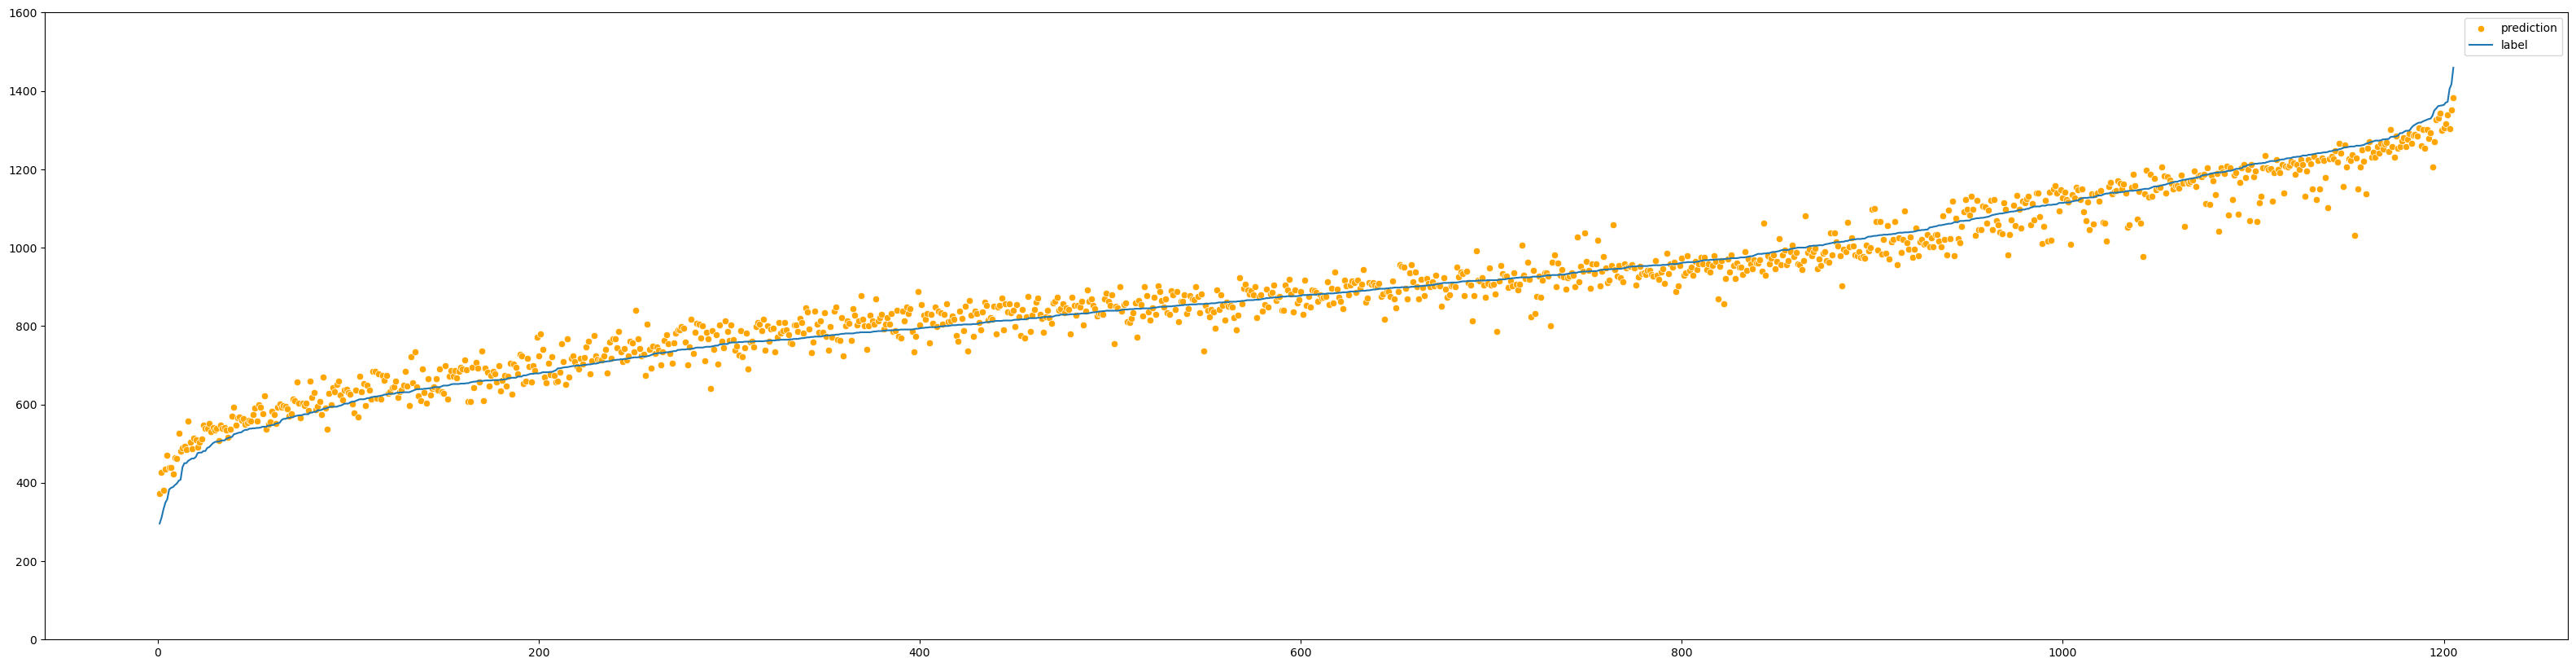

In [951]:
values = sorted(lunch_pred_labels, key=lambda x : x[1])
preds = [x[0] for x in values]
labels = [x[1] for x in values]
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(40,10))
sns.scatterplot(x=range(1, len(values) + 1), y=preds, label='prediction', c='orange')
sns.lineplot(x=range(1, len(values) + 1), y=labels, label='label')
plt.legend()
plt.ylim([0, 1600])
plt.show()

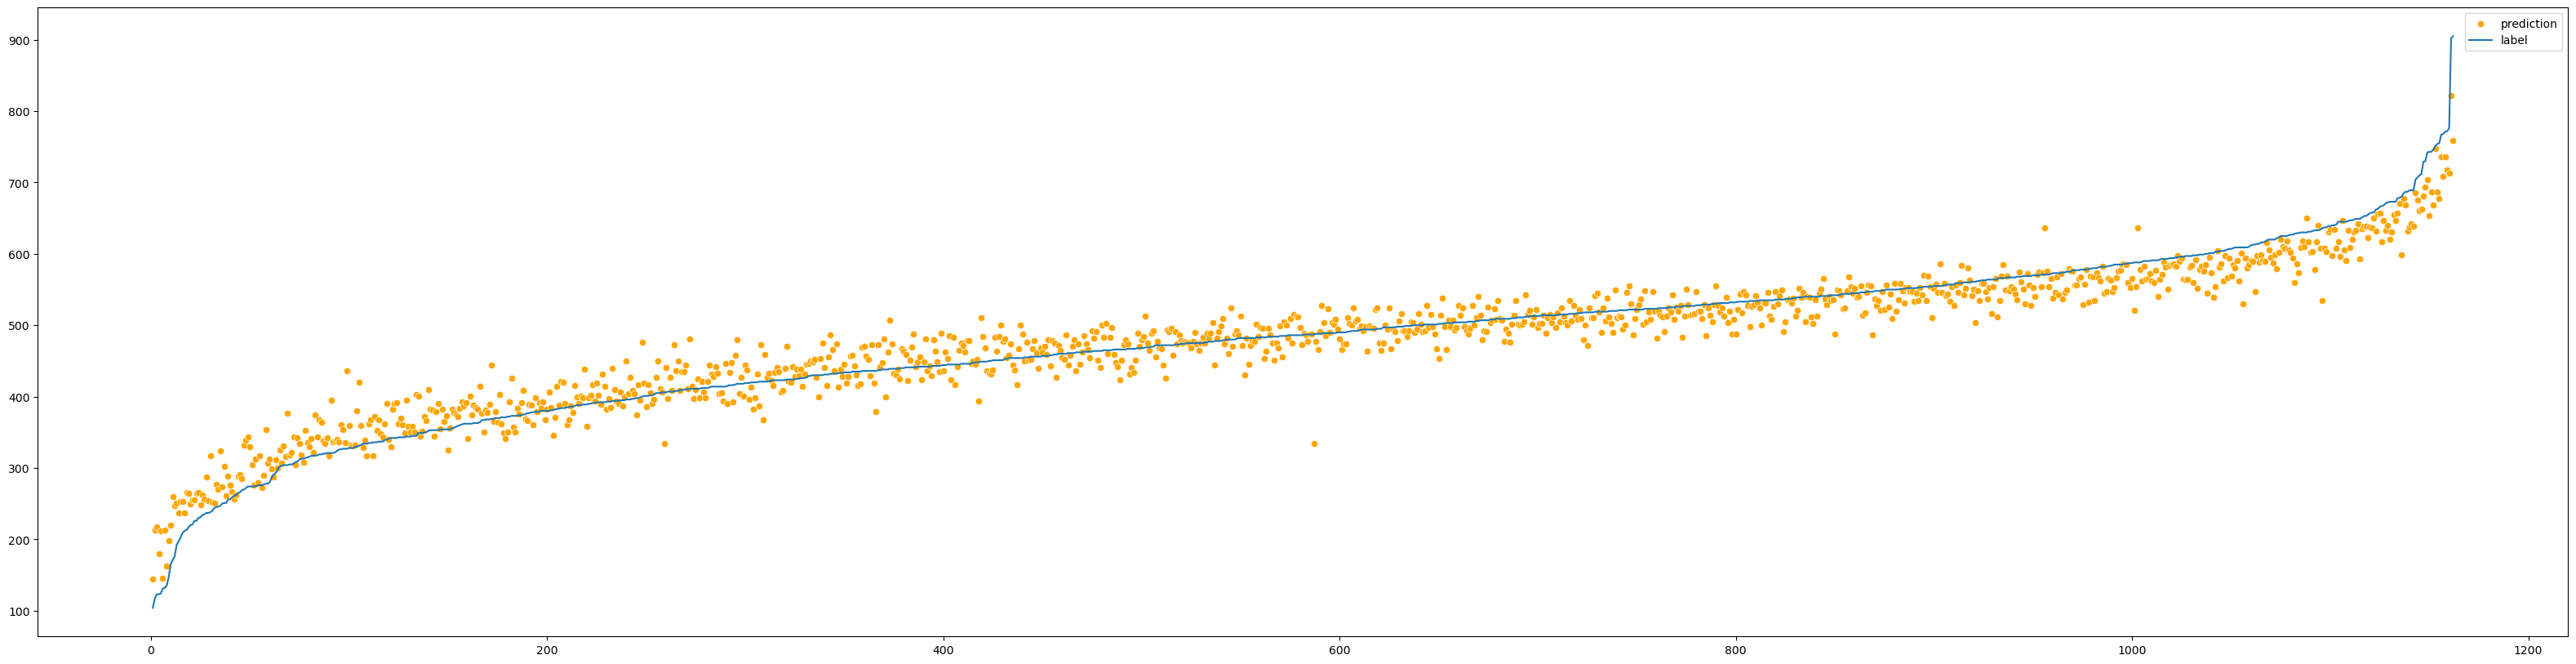

In [950]:
values = sorted(dinner_pred_labels, key=lambda x : x[1])
preds = [x[0] for x in values]
labels = [x[1] for x in values]
plt.figure(figsize=(40,10))
sns.scatterplot(x=range(1, len(values) + 1), y=preds, label='prediction', c='orange')
sns.lineplot(x=range(1, len(values) + 1), y=labels, label='label')
plt.legend()
plt.show()

# 5. Gradient Boosting으로 성능 향상해보기

GradientBoosting도 기본 베이스는 트리기반이기 때문에, 특성조합은 RandomForestRegressor에서 우수했던 특성들을 사용하고, 앙상블 자체의 하이퍼파라미터만 튜닝해보았다.

In [8]:
final_pipeline = Pipeline([
    ('feature_eng', Pipeline(steps=[('datetime', DayMonthMaker()),
                                    ('office_workers', OfficeCount()),
                                    ('categorize', MenuCategorizer()),
                                    ('lunch_ratings', RatingCalculator(meal_type='중식')),
                                    ('dinner_ratings', RatingCalculator(meal_type='석식')),
                                    ('maecom', SpicyViewer(meal_type1='중식', meal_type2='석식')),
                                    ('weekday_onehot', DayofWeekOHE())])),
    ('feature_picker', ColumnChooser(columns=['연도', '월', '요일_월', '요일_화', '요일_수', '요일_목', '요일_금',
                                             '사무실출근자수', '현본사소속재택근무자수', '본사시간외근무명령서승인건수', '본사휴가자수', '본사출장자수',
                                             '중식_해산물', '중식_채소1', '중식_채소2', '중식_채소3', '중식_육류', '중식_가공식품1', '중식_가공식품2', '중식_선호도점수',
                                             '석식_해산물', '석식_채소1', '석식_채소2', '석식_채소3', '석식_육류', '석식_가공식품1', '석식_가공식품2', '석식_선호도점수']))
     ])

**그래디언트 부스팅은 여러 타깃값을 한번에 예측하는것을 지원하지 않아서 MultipleOutputRegressor 클래스를 이용했다.**

MultipleOutputRegressor: 예측모델을 주면, fit단계에서 알아서 다차원 라벨데이터를 여러개의 1D array로 나눠서 라벨값 수만큼 훈련을 돌려준다.

In [9]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats.distributions import reciprocal, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## RandomizedSearchCV로 대략적 튜닝하기
 - 모델 1400개를 돌리는짓은 하지말자... (RandomForestRegressor 튜닝은 돌아가는데 2시간 30분이 걸렸었다.)
 - RandomizedSearchCV는 경우의 수를 입력하는것 대신, 각 파라미터의 범위와 확률분포를 입력해서 원하는 만큼만 튜닝을 시도해볼 수 있다.

In [10]:
gbr = GradientBoostingRegressor(loss='absolute_error', criterion='friedman_mse', random_state=1234)
param_dist = [{
    'learning_rate' : reciprocal(0.05,0.2), # 연속형 수치를 위한 loguniform 함수
    'n_estimators' : randint(40, 70), # 정수형 수치를 위한 randint 함수
    'subsample' : reciprocal(0.1, 1) # 연속형 수치를 위한 loguniform 함수
}]

rand_search = RandomizedSearchCV(gbr,
                                 param_distributions=param_dist,
                                 cv=5,
                                 scoring='neg_mean_absolute_error',
                                 n_jobs=-1,
                                 n_iter=100) # 모델 100개만 해보기 (교차검증까지 합치면 총 500번의 fit)
multi_reg = MultiOutputRegressor(rand_search, n_jobs=-1)
multi_reg.fit(final_pipeline.fit_transform(train, train_labels), train_labels)

MultiOutputRegressor(estimator=RandomizedSearchCV(cv=5,
                                                  estimator=GradientBoostingRegressor(loss='absolute_error',
                                                                                      random_state=1234),
                                                  n_iter=100, n_jobs=-1,
                                                  param_distributions=[{'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f866d572d60>,
                                                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f869cd6ecd0>,
                                                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f866d5722b0>}],
                                                  scoring='neg_mean_absolute_error'),
                     n_jobs=-1)

중식계 파라미터 튜닝결과

In [11]:
multi_reg.estimators_[0].best_params_, multi_reg.estimators_[0].best_score_

({'learning_rate': 0.17668805857423808,
  'n_estimators': 64,
  'subsample': 0.5315556806041138},
 -75.78733909597233)

석식계 파라미터 튜닝결과

In [12]:
multi_reg.estimators_[1].best_params_, multi_reg.estimators_[1].best_score_

({'learning_rate': 0.10946560605694516,
  'n_estimators': 67,
  'subsample': 0.8945675073039743},
 -57.86835960906111)

합친 결과로 성능지표 계산

In [13]:
from sklearn.metrics import mean_absolute_error
preds = multi_reg.predict(final_pipeline.fit_transform(train, train_labels))
mean_absolute_error(train_labels, preds)

47.79604872348111

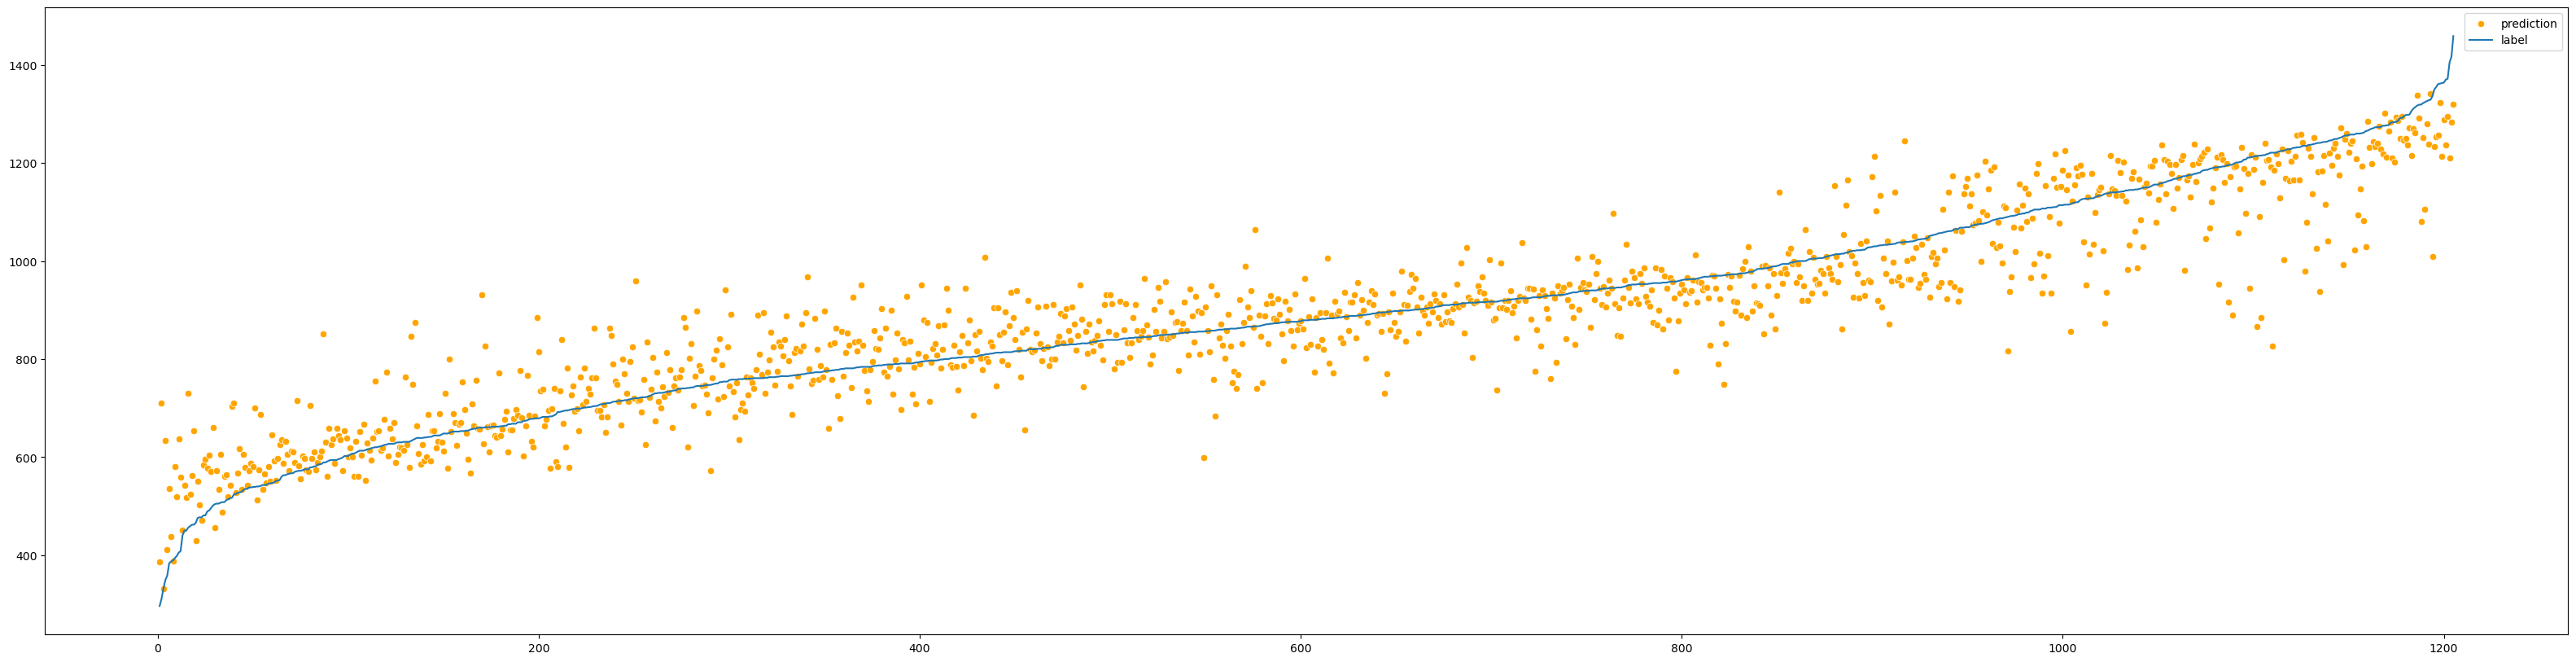

In [43]:
plt.figure(figsize=(40,10))
values = preds[:, 0].copy()
labels = list(train_labels['중식계'])
sort_ = sorted(list(zip(values, labels)), key=lambda x : x[1])
sorted_preds = [x[0] for x in sort_]
sorted_labels = [x[1] for x in sort_]
sns.scatterplot(x=range(1, len(preds) + 1), y=sorted_preds, label='prediction', c='orange')
sns.lineplot(x=range(1, len(preds) + 1), y=sorted_labels, label='label')
plt.legend()
plt.show()

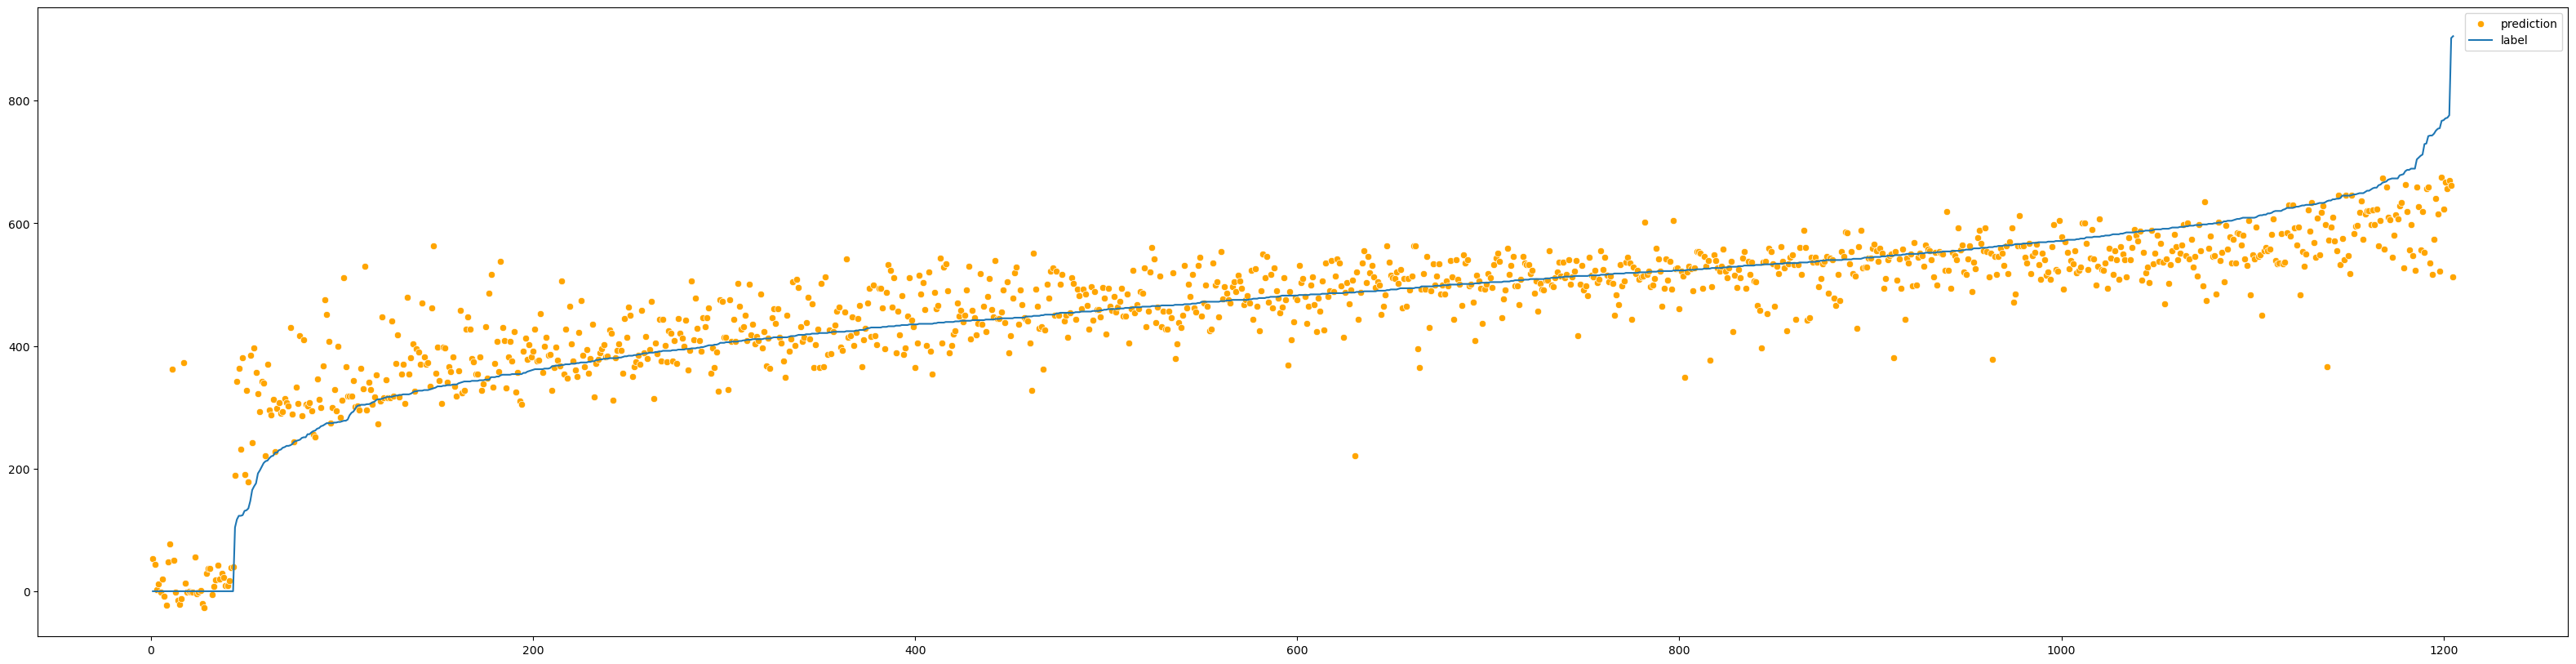

In [41]:
plt.figure(figsize=(40,10))
values = preds[:, 1].copy()
labels = list(train_labels['석식계'])
sort_ = sorted(list(zip(values, labels)), key=lambda x : x[1])
sorted_preds = [x[0] for x in sort_]
sorted_labels = [x[1] for x in sort_]
sns.scatterplot(x=range(1, len(preds) + 1), y=sorted_preds, label='prediction', c='orange')
sns.lineplot(x=range(1, len(preds) + 1), y=sorted_labels, label='label')
plt.legend()
plt.show()

## GridSearchCV로 더 자세하게 튜닝하기

In [14]:
boost_grid = {'learning_rate' : [0.1, 0.125, 0.15],
              'n_estimators':[60, 65, 70],
              'subsample':[0.5, 0.6, 0.7, 0.8, 0.9]}
grid_search = GridSearchCV(gbr, param_grid=boost_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
boost_gridcv = MultiOutputRegressor(grid_search, n_jobs=-1)
boost_gridcv.fit(final_pipeline.fit_transform(train, train_labels), train_labels)

MultiOutputRegressor(estimator=GridSearchCV(cv=5,
                                            estimator=GradientBoostingRegressor(loss='absolute_error',
                                                                                random_state=1234),
                                            n_jobs=-1,
                                            param_grid={'learning_rate': [0.1,
                                                                          0.125,
                                                                          0.15],
                                                        'n_estimators': [60, 65,
                                                                         70],
                                                        'subsample': [0.5, 0.6,
                                                                      0.7, 0.8,
                                                                      0.9]},
                                            scoring='neg_mean_absolute_error'),
                     n_jobs=-1)

중식계 튜닝 결과

In [15]:
boost_gridcv.estimators_[0].best_params_, boost_gridcv.estimators_[0].best_score_

({'learning_rate': 0.15, 'n_estimators': 70, 'subsample': 0.7},
 -75.4966267601271)

석식계 튜닝 결과

In [16]:
boost_gridcv.estimators_[1].best_params_, boost_gridcv.estimators_[1].best_score_

({'learning_rate': 0.15, 'n_estimators': 70, 'subsample': 0.8},
 -57.19848231285391)

합친 결과

In [17]:
grid_preds = boost_gridcv.predict(final_pipeline.fit_transform(train, train_labels))
mean_absolute_error(train_labels, grid_preds)

46.70290358874682

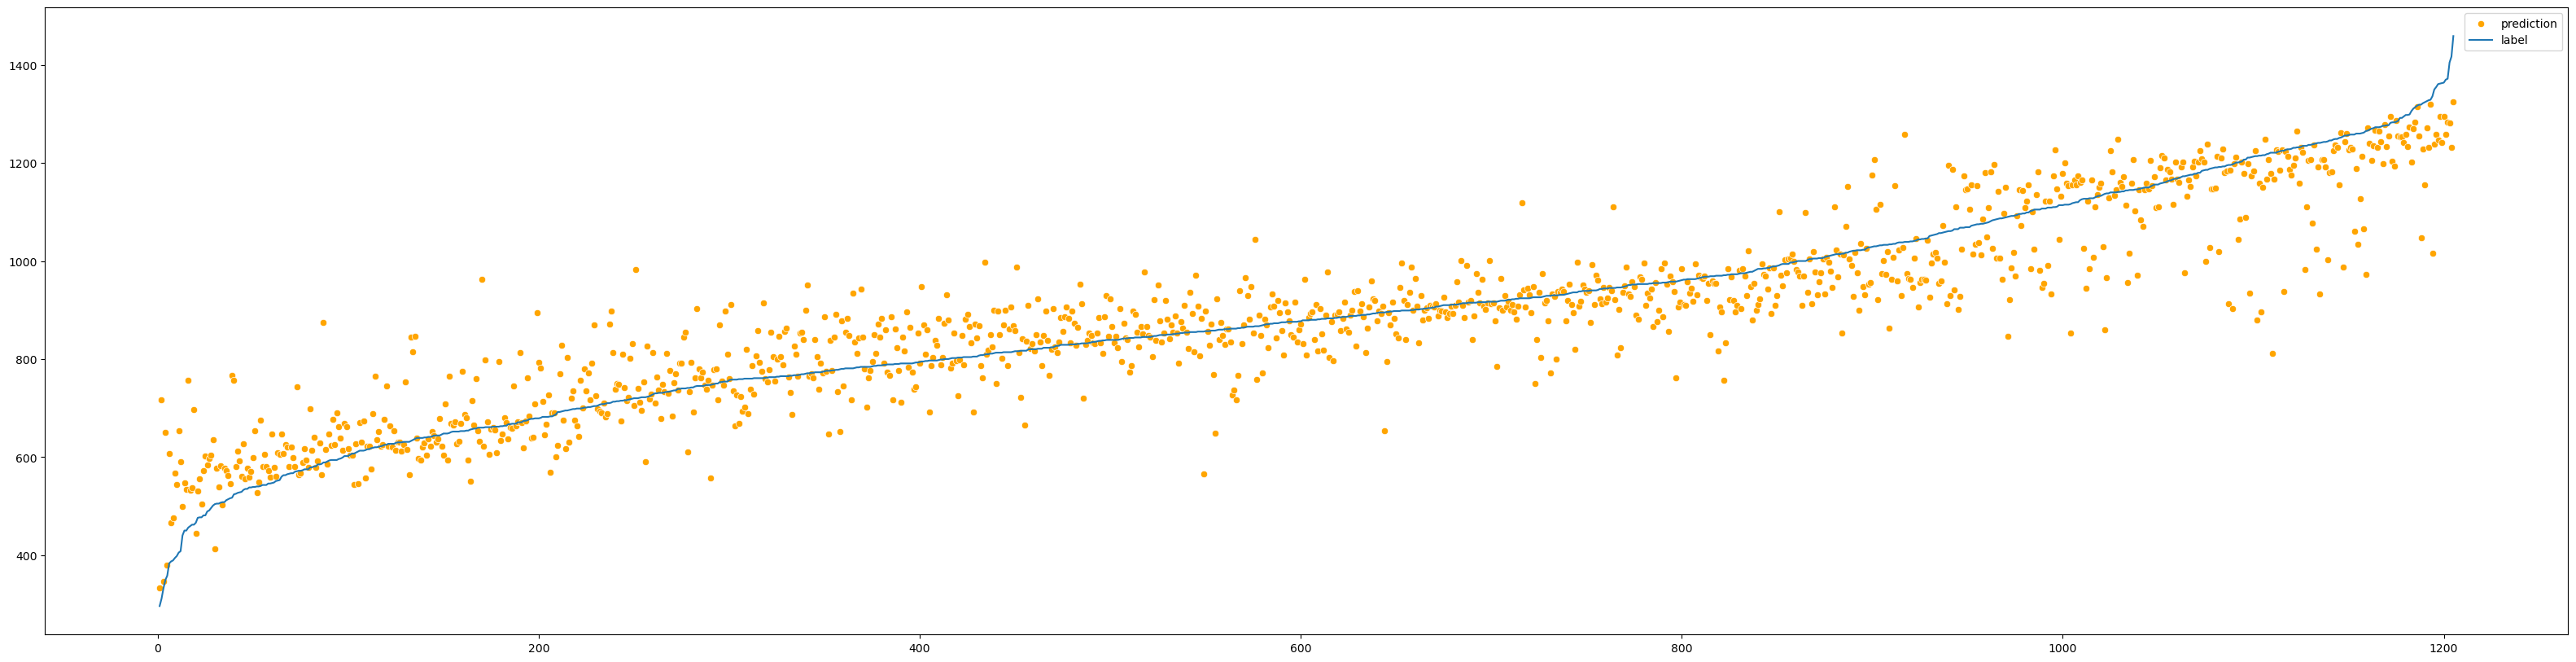

In [42]:
plt.figure(figsize=(40,10))
values = grid_preds[:, 0].copy()
labels = list(train_labels['중식계'])
sort_ = sorted(list(zip(values, labels)), key=lambda x : x[1])
sorted_preds = [x[0] for x in sort_]
sorted_labels = [x[1] for x in sort_]
sns.scatterplot(x=range(1, len(preds) + 1), y=sorted_preds, label='prediction', c='orange')
sns.lineplot(x=range(1, len(preds) + 1), y=sorted_labels, label='label')
plt.legend()
plt.show()

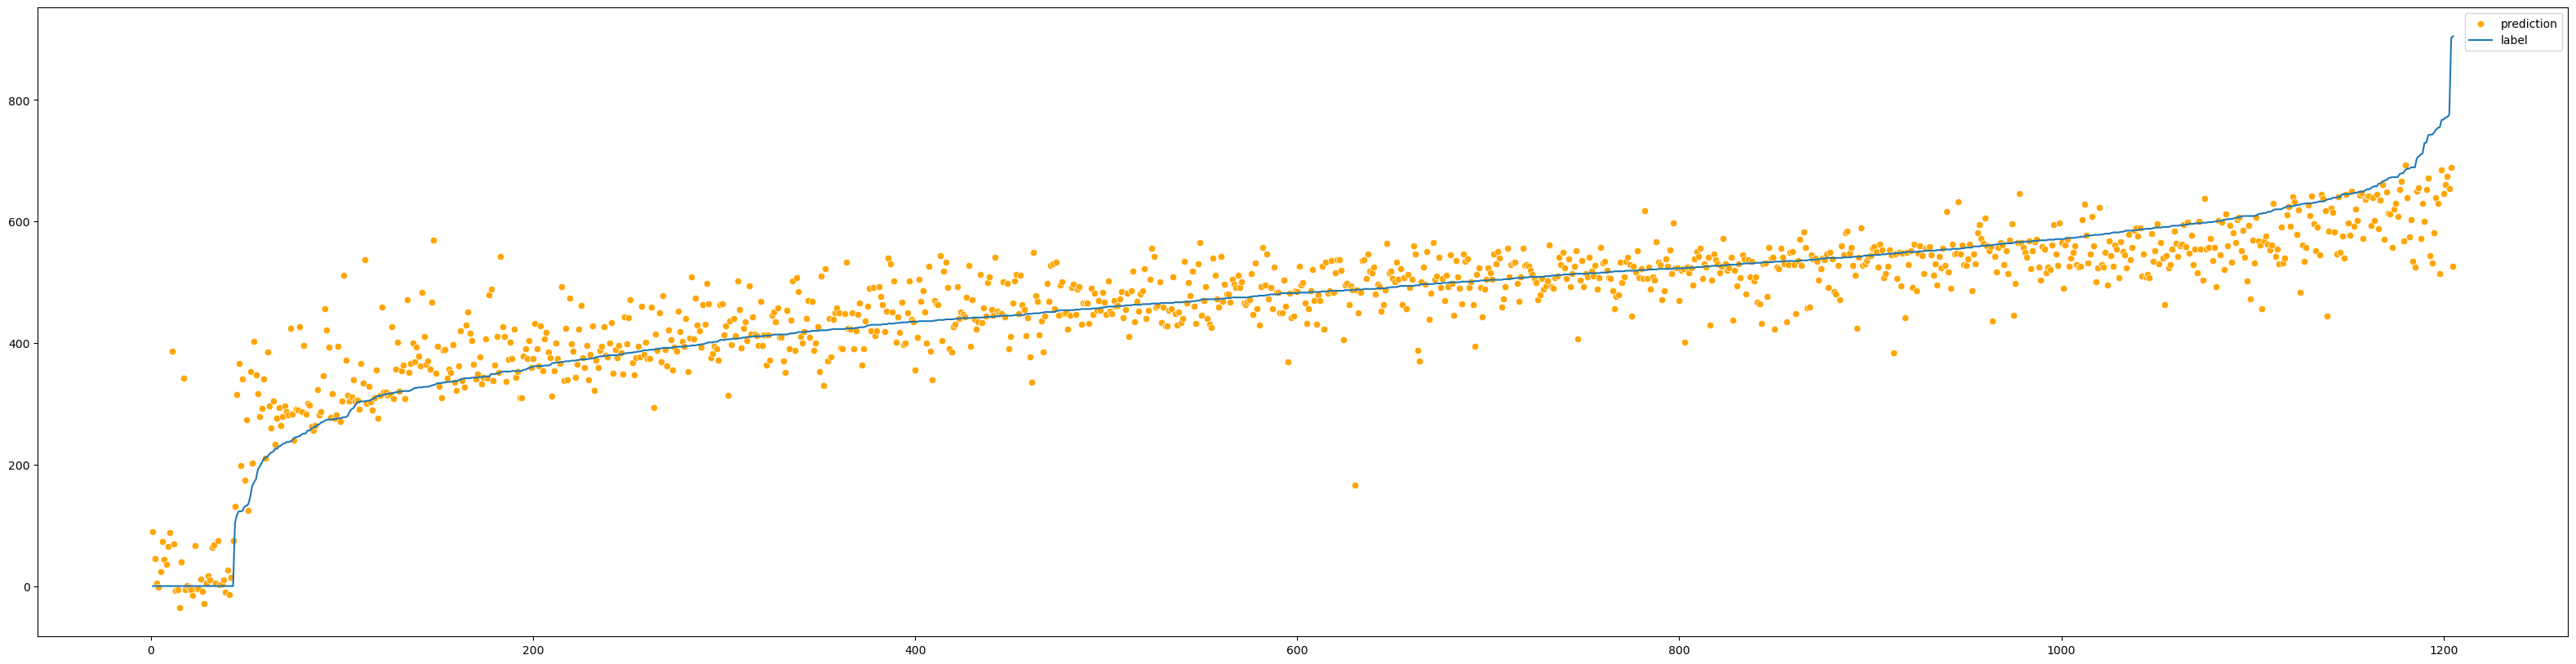

In [44]:
plt.figure(figsize=(40,10))
values = grid_preds[:, 1].copy()
labels = list(train_labels['석식계'])
sort_ = sorted(list(zip(values, labels)), key=lambda x : x[1])
sorted_preds = [x[0] for x in sort_]
sorted_labels = [x[1] for x in sort_]
sns.scatterplot(x=range(1, len(preds) + 1), y=sorted_preds, label='prediction', c='orange')
sns.lineplot(x=range(1, len(preds) + 1), y=sorted_labels, label='label')
plt.legend()
plt.show()

# 6. 부스팅 결과 데이콘에 채점해보기

In [40]:
boost_preds = boost_gridcv.predict(final_pipeline.transform(test)).round()
with open('boost_submission.csv', 'w') as fd:
    fd.write('일자,중식계,석식계\n')
    for row, pred in enumerate(boost_preds):
        date = test.iloc[row]['일자']
        lunch = pred[0]
        dinner = pred[1]
        fd.write(f'{date},{lunch},{dinner}\n')